In [ ]:
!rm -rf processed/

In [ ]:
!pip install -q opencv-python-headless tqdm
# If you’ll write video with ffmpeg:
!apt-get -y -qq install ffmpeg

unzip the folder for original images

In [ ]:
from zipfile import ZipFile
with ZipFile("original.zip", 'r') as zip_ref:
    zip_ref.extractall("original")

main code for the whole folder of images version 1

In [ ]:
import cv2, numpy as np

####################### 0808 ##############################
# ===== Your original per-frame processing, as a function =====
# def process_one(orig_bgr, TARGET_W=0):
    # # ---- 1. Optional resize (keep same for all frames!) ----
    # if TARGET_W:
    #     h, w = orig_bgr.shape[:2]
    #     orig_bgr = cv2.resize(orig_bgr, (TARGET_W, int(h*TARGET_W/w)),
    #                           interpolation=cv2.INTER_AREA)

    # # ---- 2. Split channels and process RED only ----
    # b, g, r = cv2.split(orig_bgr)
    # r = cv2.fastNlMeansDenoising(r, None, h=10, templateWindowSize=7, searchWindowSize=21)
    # clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
    # r = clahe.apply(r)
    # blur = cv2.GaussianBlur(r, (0,0), sigmaX=1.0)
    # r    = cv2.addWeighted(r, 1.20, blur, -0.20, 0)
    # enhanced = cv2.merge([b, g, r])

    # # ---- 4. Gamma tweak ----
    # GAMMA = 1.1   # >1 darkens, <1 brightens (your comment says; OpenCV LUT here follows your code)
    # lut = np.array([((i/255.0)**(1.0/GAMMA))*255 for i in range(256)], dtype=np.uint8)
    # enhanced = cv2.LUT(enhanced, lut)

    # # ---- 5. Copy original Hue & Saturation ----
    # orig_hsv     = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2HSV)
    # enhanced_hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    # enhanced_hsv[...,0] = orig_hsv[...,0]   # Hue
    # enhanced_hsv[...,1] = orig_hsv[...,1]   # Sat
    # colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
    # return colour_fixed

################### 0811 #######################
def process_one(orig, TARGET_W=0):
    if TARGET_W:
        h, w = orig.shape[:2]
        orig = cv2.resize(orig, (TARGET_W, int(h*TARGET_W/w)),
                          interpolation=cv2.INTER_AREA)

    # ---- 2. Split channels and process RED only -------------------------------
    b, g, r = cv2.split(orig)                     # keep originals of B & G

    r = cv2.fastNlMeansDenoising(                 # denoise
            r, None, h=20, templateWindowSize=7, searchWindowSize=30)

    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
    #clahe = cv2.createCLAHE(clipLimit=0.4, tileGridSize=(8,8))
    r = clahe.apply(r)                            # local contrast boost

    blur = cv2.GaussianBlur(r, (0,0), sigmaX=1.0) # un-sharp mask
    r    = cv2.addWeighted(r, 1.2, blur, -0.2, 0)

    # ---- 3. Merge B & G back, yielding "detail-enhanced" frame -----------------
    enhanced = cv2.merge([b, g, r])

    # ---- 4. Gamma tweak (optional, same as before) -----------------------------
    GAMMA = 1.1
    #GAMMA = 0.9
    #GAMMA = 1.3                                   # >1 darkens, <1 brightens
    lut = np.array([((i/255.0)**(1.0/GAMMA))*255 for i in range(256)],
                  dtype=np.uint8)
    enhanced = cv2.LUT(enhanced, lut)

    # ---- 5. ***NEW STEP*** – copy original Hue & Saturation --------------------
    orig_hsv      = cv2.cvtColor(orig,      cv2.COLOR_BGR2HSV)
    enhanced_hsv  = cv2.cvtColor(enhanced,  cv2.COLOR_BGR2HSV)

    enhanced_hsv[...,0] = orig_hsv[...,0]   # Hue  (0–179)
    enhanced_hsv[...,1] = orig_hsv[...,1]   # Sat  (0–255)

    colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

    return colour_fixed

###############################################

from pathlib import Path
from tqdm import tqdm
import re, cv2

IN_DIR  = Path("original/original")
OUT_DIR = Path("processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Natural sort to be safe (0001..0477 should already sort correctly)
def natsort_key(p: Path):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p.name)]

files = sorted(IN_DIR.glob("0.5MHzEkoScan.mov*.png"), key=natsort_key)
assert len(files) == 477, f"Expected 477 frames, found {len(files)}"

# IMPORTANT: keep size fixed for video; so TARGET_W = 0 (no resize)
TARGET_W = 0

for i, f in enumerate(tqdm(files, desc="Processing frames")):
    img = cv2.imread(str(f), cv2.IMREAD_COLOR)
    out = process_one(img, TARGET_W=TARGET_W)
    # Save with the SAME name (or with zero-padded index—either is fine)
    cv2.imwrite(str(OUT_DIR / f.name), out, [cv2.IMWRITE_PNG_COMPRESSION, 9])  # PNG is lossless

Processing frames: 100%|██████████| 477/477 [1:09:17<00:00,  8.72s/it]


modified version 2

In [ ]:
import re
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np

# ---------- User-tweakable parameters ----------
IN_DIR  = Path("original/original")
OUT_DIR = Path("processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# speck detection
PERCENTILE = 4.0          # percentile of darkest pixels to consider when thresholding L channel
SMALL_MAX_AREA = 200      # max pixel area to treat as a 'speck' (increase if dots are larger)
SMALL_MIN_AREA = 1
MAX_DIM_FOR_COMPONENT = 40  # ignore very long/thin components (likely structure) if bigger than this

# temporal smoothing for masks
# 0 = no smoothing; 1 = use current +/-1 frame (window size 3)
TEMPORAL_WINDOW = 1

# inpaint settings
INPAINT_RADIUS = 3
INPAINT_METHOD = cv2.INPAINT_TELEA  # or cv2.INPAINT_NS

# red-channel enhancement params (kept from your original script)
FASTNLMEANS_H = 10
CLAHE_CLIP = 0.1
CLAHE_TILE = (8, 8)
GAMMA = 1.1

# ------------------------------------------------

def natsort_key(p: Path):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p.name)]

def detect_speck_mask(img_bgr, percentile=PERCENTILE, small_max_area=SMALL_MAX_AREA,
                      small_min_area=SMALL_MIN_AREA, max_dim=MAX_DIM_FOR_COMPONENT):
    """
    Return a uint8 mask (0/255) marking small dark specks to be removed.
    Detection is performed on Lab L channel to avoid color bias.
    """
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
    L = lab[..., 0]
    Lblur = cv2.medianBlur(L, 3)

    # dynamic threshold by percentile, clamped to avoid extremes
    th = int(np.percentile(Lblur, percentile))
    th = max(th, 8)
    th = min(th, 60)

    mask_dark = (Lblur <= th).astype(np.uint8)

    # connected components and area filtering
    nlabels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_dark, connectivity=8)
    out_mask = np.zeros_like(mask_dark, dtype=np.uint8)

    for lab_id in range(1, nlabels):
        area = stats[lab_id, cv2.CC_STAT_AREA]
        w = stats[lab_id, cv2.CC_STAT_WIDTH]
        h = stats[lab_id, cv2.CC_STAT_HEIGHT]
        if small_min_area <= area <= small_max_area and max(w, h) <= max_dim:
            out_mask[labels == lab_id] = 255

    # remove tiny single-pixel junk and smooth mask a little
    out_mask = cv2.morphologyEx(out_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    out_mask = cv2.morphologyEx(out_mask, cv2.MORPH_DILATE, np.ones((2, 2), np.uint8))
    return out_mask

def process_one(orig_bgr, mask_specks=None, target_w=0):
    """
    orig_bgr: input BGR image (numpy array)
    mask_specks: optional uint8 mask (0/255) marking places to inpaint; if None, will compute per-frame
    returns processed BGR image
    """

    # Optional resize (kept for compatibility, default disabled)
    if target_w:
        h, w = orig_bgr.shape[:2]
        orig_bgr = cv2.resize(orig_bgr, (target_w, int(h * target_w / w)),
                              interpolation=cv2.INTER_AREA)

    # If no mask provided, detect per-frame
    if mask_specks is None:
        mask_specks = detect_speck_mask(orig_bgr)

    # Inpaint only the specks
    if mask_specks.sum() > 0:
        inpainted = cv2.inpaint(orig_bgr, mask_specks, INPAINT_RADIUS, INPAINT_METHOD)
    else:
        inpainted = orig_bgr.copy()

    # Now apply the red-channel enhancements similar to your original code
    b, g, r = cv2.split(inpainted)

    # denoise the red channel a bit
    r = cv2.fastNlMeansDenoising(r, None, h=FASTNLMEANS_H, templateWindowSize=7, searchWindowSize=21)

    # CLAHE on red
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
    r = clahe.apply(r)

    # Unsharp-ish contrast tweak (same weights as you had)
    blur = cv2.GaussianBlur(r, (0, 0), sigmaX=1.0)
    r = cv2.addWeighted(r, 1.20, blur, -0.20, 0)

    # Merge back
    enhanced = cv2.merge([b, g, r])

    # Gamma tweak as in your script (note: in your comment you reversed sign; this matches your original LUT)
    lut = np.array([((i / 255.0) ** (1.0 / GAMMA)) * 255 for i in range(256)], dtype=np.uint8)
    enhanced = cv2.LUT(enhanced, lut)

    # Preserve original Hue & Saturation from original (pre-inpainted original)
    orig_hsv = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2HSV)
    enhanced_hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    enhanced_hsv[..., 0] = orig_hsv[..., 0]
    enhanced_hsv[..., 1] = orig_hsv[..., 1]
    colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

    return colour_fixed

def temporal_combined_mask(file_list, idx, window=TEMPORAL_WINDOW):
    """
    Build a temporally-stable speck mask by OR-ing masks from neighbors.
    window = 0 -> only current frame
    window = 1 -> current +/-1 (3 frames)
    window = N -> current +/-N
    """
    left = max(0, idx - window)
    right = min(len(file_list) - 1, idx + window)
    combined = None
    for j in range(left, right + 1):
        imgj = cv2.imread(str(file_list[j]), cv2.IMREAD_COLOR)
        if imgj is None:
            continue
        mj = detect_speck_mask(imgj)
        if combined is None:
            combined = mj
        else:
            combined = cv2.bitwise_or(combined, mj)
    if combined is None:
        combined = np.zeros((1, 1), dtype=np.uint8)
    # optionally small morphological smoothing
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    return combined

def main():
    files = sorted(IN_DIR.glob("0.5MHzEkoScan.mov*.png"), key=natsort_key)
    if len(files) == 0:
        raise SystemExit("No input files found with pattern in IN_DIR.")
    print(f"Found {len(files)} frames; processing to {OUT_DIR}")

    for i, f in enumerate(tqdm(files, desc="Processing frames")):
        img = cv2.imread(str(f), cv2.IMREAD_COLOR)
        if img is None:
            print("warning: failed to read", f)
            continue

        if TEMPORAL_WINDOW > 0:
            stable_mask = temporal_combined_mask(files, i, window=TEMPORAL_WINDOW)
        else:
            stable_mask = detect_speck_mask(img)

        out = process_one(img, mask_specks=stable_mask, target_w=0)
        cv2.imwrite(str(OUT_DIR / f.name), out, [cv2.IMWRITE_PNG_COMPRESSION, 9])

if __name__ == "__main__":
    main()


version 3

In [ ]:
import os, re
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import cv2, numpy as np
from tqdm import tqdm

# =======================
# Global/precomputed stuff
# =======================
cv2.setUseOptimized(True)
# Let OpenCV decide threads (good default). If you see CPU thrash, cap it:
# cv2.setNumThreads(max(1, os.cpu_count()//2))

# ---- Reusable ops ----
CLAHE = cv2.createCLAHE(clipLimit=0.10, tileGridSize=(8, 8))  # keep your value
GAMMA = 1.1
LUT = np.array([((i/255.0)**(1.0/GAMMA))*255 for i in range(256)], dtype=np.uint8)

# Tunables (start here to match the AI-like look)
#MED_KSIZE   = 3      # median kills salt/pepper (odd, >=3). Try 5 if dots persist.
MED_KSIZE   = 1
#BIL_SIG_C   = 18     # bilateral sigmaColor (try 14–26). Higher → smoother, slower.
BIL_SIG_C = 30
BIL_SIG_S   = 3      # bilateral sigmaSpace (2–5). Larger spreads smoothing.
USM_AMOUNT  = 0.18   # unsharp mask negative weight (0.12–0.25)
USM_SIGMA   = 0.9    # Gaussian sigma for USM (0.8–1.2)

PNG_COMP    = 3      # 0–9. Lower = faster. 3 is a good speed/size tradeoff.

def process_one(orig_bgr, TARGET_W=0):
    # 1) Optional resize (unchanged)
    if TARGET_W:
        h, w = orig_bgr.shape[:2]
        orig_bgr = cv2.resize(orig_bgr, (TARGET_W, int(h*TARGET_W/w)), interpolation=cv2.INTER_AREA)

    # 2) Work only on RED, but keep B/G for merge later
    b, g, r = cv2.split(orig_bgr)

    # --- Fast speckle-oriented chain (replaces slow fastNlMeansDenoising) ---
    # a) kill salt/pepper dots quickly
    r_med = cv2.medianBlur(r, MED_KSIZE)

    # b) edge-preserving smoothing to quiet background grain without flattening the wave
    #    Using small sigmaSpace keeps edges standing; sigmaColor controls smoothing strength.
    r_bil = cv2.bilateralFilter(r_med, d=0, sigmaColor=BIL_SIG_C, sigmaSpace=BIL_SIG_S)

    # c) mild local contrast + stabilization
    r_eq  = CLAHE.apply(r_bil)

    # d) subtle unsharp mask to “stand” the wave without bringing noise back
    blur  = cv2.GaussianBlur(r_eq, (0,0), sigmaX=USM_SIGMA)
    r_usm = cv2.addWeighted(r_eq, 1.0 + USM_AMOUNT, blur, -USM_AMOUNT, 0)

    enhanced = cv2.merge([b, g, r_usm])

    # 4) Gamma tweak (same as yours)
    enhanced = cv2.LUT(enhanced, LUT)

    # 5) Copy original Hue & Saturation (preserve look; avoid unwanted color shifts)
    orig_hsv     = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2HSV)
    enhanced_hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
    enhanced_hsv[...,0] = orig_hsv[...,0]
    enhanced_hsv[...,1] = orig_hsv[...,1]
    colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

    return colour_fixed

# =======================
# Batch I/O (parallelized)
# =======================
IN_DIR  = Path("original/original")
OUT_DIR = Path("processed_v4")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def natsort_key(p: Path):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p.name)]

files = sorted(IN_DIR.glob("0.5MHzEkoScan.mov*.png"), key=natsort_key)
assert len(files) == 477, f"Expected 477 frames, found {len(files)}"

TARGET_W = 0  # keep original size for video

def _work_one(fpath: Path):
    img = cv2.imread(str(fpath), cv2.IMREAD_COLOR)
    out = process_one(img, TARGET_W=TARGET_W)
    out_path = OUT_DIR / fpath.name
    ok = cv2.imwrite(str(out_path), out, [cv2.IMWRITE_PNG_COMPRESSION, PNG_COMP])
    return fpath.name, ok

# Use threads: OpenCV releases the GIL in most heavy ops; writing PNG is I/O bound too.
max_workers = max(1, os.cpu_count() or 4)
with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = [ex.submit(_work_one, f) for f in files]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing frames", smoothing=0.05):
        pass


In [ ]:
from pathlib import Path
proc = Path("original/original")  # or your folder path
imgs = sorted(proc.glob("0.5MHzEkoScan.mov*.png"))
print(len(imgs), "frames")
print([p.name for p in imgs[:3]])
print([p.name for p in imgs[-3:]])

477 frames
['0.5MHzEkoScan.mov0001.png', '0.5MHzEkoScan.mov0002.png', '0.5MHzEkoScan.mov0003.png']
['0.5MHzEkoScan.mov0475.png', '0.5MHzEkoScan.mov0476.png', '0.5MHzEkoScan.mov0477.png']


In [ ]:
!ffmpeg -y -framerate 24 -i original/original/0.5MHzEkoScan.mov%04d.png \
        -c:v libx264 -preset slow -crf 0 -pix_fmt yuv444p original_h264.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

combining all the images back to a video

In [ ]:
from pathlib import Path
proc = Path("processed")  # or your folder path
imgs = sorted(proc.glob("0.5MHzEkoScan.mov*.png"))
print(len(imgs), "frames")
print([p.name for p in imgs[:3]])
print([p.name for p in imgs[-3:]])

477 frames
['0.5MHzEkoScan.mov0001.png', '0.5MHzEkoScan.mov0002.png', '0.5MHzEkoScan.mov0003.png']
['0.5MHzEkoScan.mov0475.png', '0.5MHzEkoScan.mov0476.png', '0.5MHzEkoScan.mov0477.png']


In [ ]:
!apt -y -qq install ffmpeg

ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!ffmpeg -y -framerate 24 -i processed/0.5MHzEkoScan.mov%04d.png \
        -c:v libx264 -preset slow -crf 0 -pix_fmt yuv444p output_lossless_h264.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!ffmpeg -i output_lossless_h264.mp4 -c copy output.mp4

In [ ]:
!zip -r processed_frames.zip processed
from google.colab import files
files.download("processed_frames.zip")

  adding: processed/ (stored 0%)
  adding: processed/0.5MHzEkoScan.mov0347.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0336.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0399.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0471.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0218.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0006.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0119.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0111.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0236.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0216.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0028.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0287.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0017.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0086.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0035.png (deflated 0%)
  adding: processed/0.5MHzEkoScan.mov0448.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from zipfile import ZipFile
with ZipFile("processed.zip", 'r') as zip_ref:
    zip_ref.extractall("processed")

single image

Saved → 81_v1.png


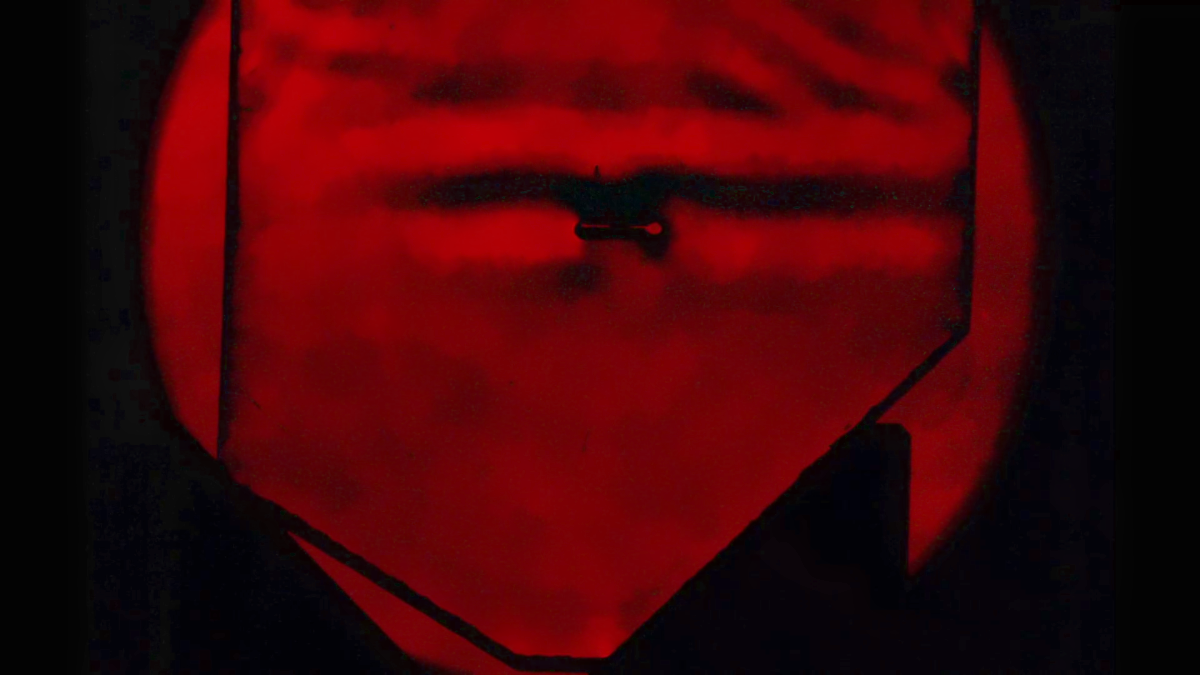

In [ ]:
# =============================================================
# Same processing, but hue & saturation copied from the original
# =============================================================
!pip install -q opencv-python-headless

import cv2, numpy as np
from pathlib import Path
from google.colab.patches import cv2_imshow   # quick preview

#RAW = '0.5MHzEkoScan.mov0330.png'
#RAW = '0.5MHzEkoScan.mov0149.png'             # ← upload before running
RAW = '0.5MHzEkoScan.mov0081.png'
assert Path(RAW).exists(), f'Upload {RAW} first!'
orig = cv2.imread(RAW)                        # BGR (OpenCV default)

# ---- 1. (Optional) resize so it matches your reference width ----
TARGET_W = 1200                               # 0 → keep original size
if TARGET_W:
    h, w = orig.shape[:2]
    orig = cv2.resize(orig, (TARGET_W, int(h*TARGET_W/w)),
                      interpolation=cv2.INTER_AREA)

# ---- 2. Split channels and process RED only -------------------------------
b, g, r = cv2.split(orig)                     # keep originals of B & G

r = cv2.fastNlMeansDenoising(                 # denoise
        r, None, h=10, templateWindowSize=7, searchWindowSize=40)

#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
#clahe = cv2.createCLAHE(clipLimit=0.4, tileGridSize=(8,8))
r = clahe.apply(r)                            # local contrast boost

blur = cv2.GaussianBlur(r, (0,0), sigmaX=1.0) # un-sharp mask
r    = cv2.addWeighted(r, 1.2, blur, -0.2, 0)

# ---- 3. Merge B & G back, yielding "detail-enhanced" frame -----------------
enhanced = cv2.merge([b, g, r])

# ---- 4. Gamma tweak (optional, same as before) -----------------------------
GAMMA = 1.1
#GAMMA = 0.9
#GAMMA = 1.3                                   # >1 darkens, <1 brightens
lut = np.array([((i/255.0)**(1.0/GAMMA))*255 for i in range(256)],
               dtype=np.uint8)
enhanced = cv2.LUT(enhanced, lut)

# ---- 5. ***NEW STEP*** – copy original Hue & Saturation --------------------
orig_hsv      = cv2.cvtColor(orig,      cv2.COLOR_BGR2HSV)
enhanced_hsv  = cv2.cvtColor(enhanced,  cv2.COLOR_BGR2HSV)

enhanced_hsv[...,0] = orig_hsv[...,0]   # Hue  (0–179)
enhanced_hsv[...,1] = orig_hsv[...,1]   # Sat  (0–255)

colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

# ---- 6. Save & preview ------------------------------------------------------
OUT = '81_v1.png'
#OUT = '149_v1.png'
#OUT = '330_v1.png'
cv2.imwrite(OUT, colour_fixed)
print(f'Saved → {OUT}')
cv2_imshow(colour_fixed)


single image version 2

In [ ]:
# =============================================================
# One-frame "zero black dots in background" cleaning
# (protects wave, removes tiny dark specks via inpainting)
# =============================================================
!pip install -q opencv-python-headless

import cv2, numpy as np
from pathlib import Path
from google.colab.patches import cv2_imshow

# -------- Tunables (adjust only if needed) --------
TARGET_W   = 1200        # 0 to keep original size
A_MAX      = 30          # max area (in px) for a dot to be removed (20–50)
INPAINT_R  = 3           # inpaint radius (2–4)
BIL_SIG_C  = 22          # background-only smoothing strength (12–22)
BIL_SIG_S  = 3           # background-only spatial smoothing (2–4)
USM_AMOUNT = 0.15        # unsharp mask amount for wave (0.12–0.22)
USM_SIGMA  = 0.9         # unsharp mask sigma (0.8–1.2)
GAMMA      = 1.1         # keep your gamma
# --------------------------------------------------

#RAW = '0.5MHzEkoScan.mov0330.png'
#RAW = '0.5MHzEkoScan.mov0149.png'
RAW = '0.5MHzEkoScan.mov0001.png'
assert Path(RAW).exists(), f'Upload {RAW} first!'
orig = cv2.imread(RAW)  # BGR

# 1) Optional resize
if TARGET_W:
    h, w = orig.shape[:2]
    orig = cv2.resize(orig, (TARGET_W, int(h*TARGET_W/w)), interpolation=cv2.INTER_AREA)

# 2) Work in RED channel, keep B/G for later merge
b, g, r = cv2.split(orig)

# ---- 2a. Build a "wave/structure" mask so we don't alter it ----
# Use a high-pass cue (difference of Gaussians) + Otsu, then dilate a bit
r_s  = cv2.GaussianBlur(r, (0,0), 1.2)
hp   = cv2.absdiff(r_s, cv2.GaussianBlur(r_s, (0,0), 6.0))
_, wave_mask = cv2.threshold(hp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
wave_mask = cv2.morphologyEx(wave_mask, cv2.MORPH_CLOSE, k3, iterations=1)
wave_mask = cv2.dilate(wave_mask, k3, iterations=1)        # expands protection around wave
bg_mask   = cv2.bitwise_not(wave_mask)

# ---- 2b. Detect tiny dark specks ONLY in the background ----
# Residual to local median highlights dark outliers; Otsu threshold; keep small components
med3      = cv2.medianBlur(r, 3)
resid     = cv2.subtract(med3, r)                          # positive if r is darker than local median
_, dots0  = cv2.threshold(resid, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
dots0     = cv2.bitwise_and(dots0, bg_mask)                # only background

# Remove anything too big (so we never eat into real wave troughs)
num, labels, stats, _ = cv2.connectedComponentsWithStats(dots0, connectivity=8)
dots_small = np.zeros_like(dots0)
for i in range(1, num):
    if stats[i, cv2.CC_STAT_AREA] <= A_MAX:
        dots_small[labels == i] = 255
dots_small = cv2.morphologyEx(dots_small, cv2.MORPH_OPEN, k3, iterations=1)

# ---- 2c. Inpaint to remove specks completely (background only) ----
r_fix = cv2.inpaint(r, dots_small, INPAINT_R, cv2.INPAINT_TELEA)

# ---- 2d. Smooth only the background (edge-preserving) ----
r_bg_smooth = cv2.bilateralFilter(r_fix, d=0, sigmaColor=BIL_SIG_C, sigmaSpace=BIL_SIG_S)
r_out = r_fix.copy()
r_out[bg_mask == 255] = r_bg_smooth[bg_mask == 255]        # keep wave region untouched

# ---- 2e. Mild local contrast + subtle unsharp to "stand" the wave ----
clahe = cv2.createCLAHE(clipLimit=0.10, tileGridSize=(8,8))
r_eq  = clahe.apply(r_out)
blur  = cv2.GaussianBlur(r_eq, (0,0), USM_SIGMA)
r_usm = cv2.addWeighted(r_eq, 1.0 + USM_AMOUNT, blur, -USM_AMOUNT, 0)

# 3) Merge back B/G with processed R
enhanced = cv2.merge([b, g, r_usm])

# 4) Gamma tweak (same as before)
lut = np.array([((i/255.0)**(1.0/GAMMA))*255 for i in range(256)], dtype=np.uint8)
enhanced = cv2.LUT(enhanced, lut)

# 5) Copy original Hue & Saturation to avoid color shifts
orig_hsv     = cv2.cvtColor(orig, cv2.COLOR_BGR2HSV)
enhanced_hsv = cv2.cvtColor(enhanced, cv2.COLOR_BGR2HSV)
enhanced_hsv[...,0] = orig_hsv[...,0]
enhanced_hsv[...,1] = orig_hsv[...,1]
colour_fixed = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

# 6) Save & quick preview
OUT = '1_clean.png'
cv2.imwrite(OUT, colour_fixed)
print(f'Saved → {OUT}')
cv2_imshow(colour_fixed)

# (Optional) visualize what got removed / protected for sanity checks
# cv2_imshow(dots_small)  # white = specks removed
# cv2_imshow(wave_mask)   # white = protected wave/edges
